# [CSC8101] Big Data Analytics - 2022 Spark Coursework

## Coursework overview

### Inputs

- **NYC Taxi Trips dataset** - list of recorded taxi trips, each with several characteristics, namely: distance, number of passengers, origin zone, destination zone and trip cost (total amount charged to customer).
- **NYC Zones dataset** - list of zones wherein trips can originate/terminate.

### Tasks

1. Data cleaning
  1. Remove "0 distance" and 'no passengers' records.
  2. Remove outlier records. 
2. Add new columns
  1. Join with zones dataset
  2. Compute the unit profitability of each trip
3. Zone summarisation and ranking
  1. Summarise trip data per zone
  2. Obtain the top 10 ranks according to:
    1. The total trip volume
    2. Their average profitabilitiy
    3. The total passenger volume
4. Record the total and task-specific execution times for each dataset size and format.

### How to

###### Code structure and implementation

- You must implement your solution to each task in the provided function code skeleton.
- The task-specific functions are combined together to form the full pipeline code, executed last (do not modify this code).
- Before implementing the specified function skeleton, you should develop and test your solution on separate code cells (create and destroy cells as needed).

###### Development

- Develop an initial working solution for the 'S' dataset and only then optimise it for larger dataset sizes.
- To perform vectorised operations on a DataFrame:
  - use the API docs to look for existing vectorised functions in: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions
  - if a customised function is required (e.g. to add a new column based on a linear combination of other columns), implement your own User Defined Function (UDF). See:  https://spark.apache.org/docs/latest/sql-ref-functions-udf-scalar.html
- Use only the `pyspark.sql` API - documentation link below - (note that searching through the docs returns results from the `pyspark.sql` API together with the `pyspark.pandas` API):
  - https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.sql.html
- Periodically download your notebook to your computer as backup and safety measure against accidental file deletion.
 
###### Execution time measurement

- Execution time is calculated and returned by the Spark Engine and shown in the output region of the cell.
- To measure the execution time of a task you must perform a `collect` or similar operation (e.g. `take`) on the returned DataFrame.

## Task 0 - Read data

The code below is ready to run. **Do not modify this code**. It does the following:

- Reads the 'zones' dataset into variable 'zone_names'
- Defines the `init_trips` function that allows you to read the 'trips' dataset (from the DBFS FileStore) given the dataset size ('S' to 'XXL') and format ('parquet' or 'delta') as function arguments
- Defines the `pipeline` function, called in Task 4 to measure the execution time of the entire data processing pipeline
- Shows you how to call the `init_trips` function and display dataset characteristics (number of rows, schema)

In [0]:
## global imports
import pyspark.sql as ps
import pyspark.sql.functions as pf
import pandas as pd

# Load zone names dataset - (much faster to read small file from git than dbfs)
zones_file_url = 'https://raw.githubusercontent.com/NewcastleComputingScience/csc8101-coursework/main/02-assignment-spark/taxi_zone_names.csv'
zone_names = spark.createDataFrame(pd.read_csv(zones_file_url))

# Function to load trips dataset by selected dataset size
def init_trips(size = 'S', data_format = "parquet", taxi_folder = "/FileStore/tables/taxi"):     
    
    files = {
        'S'  : ['2021_07'],
        'M'  : ['2021'],
        'L'  : ['2020_21'],
        'XL' : ['1_6_2019', '7_12_2019'],
        'XXL': ['1_6_2019', '7_12_2019', '2020_21']
    }
    
    # validate input dataset size
    if size not in files.keys():
        print("Invalid input dataset size. Must be one of {}".format(list(files.keys())))
        return None               
    
    if data_format == "parquet":
        filenames = list(map(lambda s: f'{taxi_folder}/parquet/tripdata_{s}.parquet', files[size]))
        trips_df = spark.read.parquet(filenames[0])
        
        for name in filenames[1:]:
            trips_df = trips_df.union(spark.read.parquet(name))
            
    elif data_format == "delta":
        filenames = f"{taxi_folder}/delta/taxi-{size}-delta/"
        trips_df = spark.read.format("delta").load(filenames)
    
    else:
        print("Invalid data format. Must be one of {}".format(['parquet', 'delta']))
        return None
        
    print(
    """
    Trips dataset loaded!
    ---
      Size: {s}
      Format: {f}
      Tables loaded: {ds}
      Number of trips (dataset rows): {tc:,}
    """.format(s = size, f = data_format, ds = filenames, tc = trips_df.count()))
    
    return trips_df

# helper function to print dataset row count
def print_count(df):
    print("Row count: {t:,}".format(t = df.count()))

def pipeline(trips_df, with_task_12 = False, zones_df = zone_names):
    # Do not edit
    #---

    ## Task 1.1
    _trips_11 = t11_remove_zeros(trips_df)

    ## Task 1.2
    if with_task_12:
        _trips_12 = t12_remove_outliers(_trips_11)
    else:
        _trips_12 = _trips_11

    ## Task 2.1
    _trips_21 = t21_join_zones(_trips_12, zones_df = zone_names)

    ## Task 2.2
    _trips_22 = t22_calc_profit(_trips_21)

    ## Task 3.1
    _graph = t31_summarise_trips(_trips_22)

    ## Task 3.2
    _zones = t32_summarise_zones_pairs(_graph)

    _top10_trips     = t32_top10_trips(_zones)
    _top10_profit    = t32_top10_profit(_zones)
    _top10_passenger = t32_top10_passenger(_zones)
    
    return([_top10_trips, _top10_profit, _top10_passenger])

In [0]:
# CHANGE the value of argument 'size' to record the pipeline execution times for increasing dataset sizes
SIZE = 'S'
DATA_FORMAT = 'parquet'

# Load trips dataset
trips = init_trips(SIZE, DATA_FORMAT)

# uncomment line only for small datasets
# trips.take(1)


    Trips dataset loaded!
    ---
      Size: S
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    


In [0]:
#The total number of trips
print_count(trips)

Row count: 2,898,033


In [0]:
# trips dataset schema
trips.printSchema()

root
 |-- index: long (nullable = true)
 |-- VendorID: double (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |--

In [0]:
# To display a few selected columns of the trips dataset
display(trips[['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount']].take(5))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
90,68,0.8,1.0,8.8
113,90,0.9,1.0,8.8
88,232,2.8,1.0,13.8
79,249,1.4,1.0,12.3
142,238,2.0,0.0,12.3


In [0]:
# zone_names dataset schemas
zone_names.printSchema()

root
 |-- LocationID: long (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [0]:
# Zone_name dataset
display(zone_names.take(5))

LocationID,Borough,Zone,service_zone
1,EWR,Newark Airport,EWR
2,Queens,Jamaica Bay,Boro Zone
3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,Manhattan,Alphabet City,Yellow Zone
5,Staten Island,Arden Heights,Boro Zone


## Task 1 - Filter rows

**Input:** trips dataset

### Task 1.1 - Remove "0 distance" and 'no passengers' records

Remove dataset rows that represent invalid trips:

- Trips where `trip_distance == 0` (no distance travelled)
- Trips where `passenger_count == 0` and `total_amount == 0` (we want to retain records where `total_amount` > 0 - these may be significant as the taxi may have carried some parcel, for example)

Altogether, a record is removed if it satisfies the following conditions:

`trip_distance == 0` or `(passenger_count == 0` and `total_amount == 0)`.

**Recommended:** Select only the relevant dataset columns for this and subsequent tasks: `['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount')]`

### Task 1.2 - Remove outliers using the modified z-score

Despite having removed spurious "zero passengers" trips in task 1.1, columns `total_amount` and `trip_distance` contain additional outlier values that must be identified and removed.

To identify and remove outliers, you will use the modified [z-score](https://en.wikipedia.org/wiki/Standard_score) method.
The modified z-score uses the median and [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD), instead of the mean and standard deviation, to determine how far an observation (indexed by i) is from the mean:

$$z_i = \frac{x_i - \mathit{median}(\mathbf{x})}{\mathbf{MAD}},$$

where x represents the input vector, xi is an element of x and zi is its corresponding z-score. In turn, the MAD formula is:

$$\mathbf{MAD} = 1.483 * \mathit{median}(\big\lvert x_i - \mathit{median}(\mathbf{x})\big\rvert).$$

Observations with **high** (absolute) z-score are considered outlier observations. A score is considered **high** if its __absolute z-score__ is larger than a threshold T = 3.5:

$$\big\lvert z_i \big\rvert > 3.5.$$

where T represents the number of unit standard deviations beyond which a score is considered an outlier ([wiki](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).

This process is repeated twice, once for each of the columns `total_amount` and `trip_distance` (in any order).

**Important:** Use the surrogate function [`percentile_approx`](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.functions.percentile_approx.html?highlight=percentile#pyspark.sql.functions.percentile_approx) to estimate the median (calculating the median values for a column is expensive as it cannot be parallelised efficiently).

In [0]:
# The solution implementation to task 1.1 - Removing 0 distance and no passenger records
# total_amount > 0 is retained as the taxi may have carried some parcel

def t11_remove_zeros(df):
    df=df.filter(df.trip_distance >0)
    df=df.filter(~((df.passenger_count == 0) & (df.total_amount ==0)))
    
    # Recommended columns selected    
    df=df.select(['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount'  ])
    return df

In [0]:
# execute task 1.1
trips_11 = t11_remove_zeros(trips)
## uncomment only for smaller datasets
display(trips_11.take(10))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
90,68,0.8,1.0,8.8
113,90,0.9,1.0,8.8
88,232,2.8,1.0,13.8
79,249,1.4,1.0,12.3
142,238,2.0,0.0,12.3
114,90,1.6,1.0,12.8
90,144,1.8,1.0,13.3
114,48,2.0,1.0,14.75
48,152,5.7,1.0,22.3
234,148,1.8,1.0,14.75


In [0]:
# solution implementation to task 1.2 - Removing outliers using the modified z-score
from pyspark.sql import functions as F

def t12_remove_outliers(df):
    total_amount_median= df.agg(F.percentile_approx("total_amount", 0.5, F.lit(1000))).collect()[0][0]
    trip_distance_median = df.agg(F.percentile_approx("trip_distance", 0.5, F.lit(1000))).collect()[0][0]
    delta_total_amount=F.abs(df.total_amount-total_amount_median)
    delta_trip_distance=F.abs(df.trip_distance-trip_distance_median)
    mad_total_amount=df.agg(F.percentile_approx(delta_total_amount, 0.5, F.lit(1000))).collect()[0][0]*1.483
    mad_trip_distance=df.agg(F.percentile_approx(delta_trip_distance, 0.5, F.lit(1000))).collect()[0][0]*1.483
    z_score_total_amount=((df.total_amount-total_amount_median)/mad_total_amount)
    z_score_trip_distance=((df.trip_distance-trip_distance_median)/mad_trip_distance)
    df=df.withColumn('z_score_total_amount',z_score_total_amount)
    df=df.withColumn('z_score_trip_distance',z_score_trip_distance)
    df=df.filter((F.abs(df.z_score_total_amount)<3.5) & (F.abs(df.z_score_trip_distance)<3.5))
    return df
  


In [0]:
# execute task 1.2
trips_12 = t12_remove_outliers(trips_11)
print(trips_12)
trips_12=trips_12.select(['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount'])
display(trips_12.take(10))

DataFrame[PULocationID: bigint, DOLocationID: bigint, trip_distance: double, passenger_count: double, total_amount: double, z_score_total_amount: double, z_score_trip_distance: double]


PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
90,68,0.8,1.0,8.8
113,90,0.9,1.0,8.8
88,232,2.8,1.0,13.8
79,249,1.4,1.0,12.3
142,238,2.0,0.0,12.3
114,90,1.6,1.0,12.8
90,144,1.8,1.0,13.3
114,48,2.0,1.0,14.75
48,152,5.7,1.0,22.3
234,148,1.8,1.0,14.75


In [0]:
#initial number of rows
print("Initial number of rows before data processing: ")
print_count(trips)

# The number of rows filtered after removing outliers using the modified z score method
print("The number of rows after Remove 0 distance and no passengers records: ")
print_count(trips_11)

# The number of rows filtered after removing 0 distance and no passenger record.
print("The number of rows after removing outliers: ")
print_count(trips_12)

Initial number of rows before data processing: 
Row count: 2,898,033
The number of rows after Remove 0 distance and no passengers records: 
Row count: 2,858,164
The number of rows after removing outliers: 
Row count: 2,495,635


## Task 2 - Compute new columns

### Task 2.1 - Zone names

Obtain the **start** and **end** zone names of each trip by joining the `trips` and `zone_names` datasets (i.e. by using the `zone_names` dataset as lookup table).

**Note:** The columns containing the start and end zone ids of each trip are named `PULocationID` and `DOLocationID`, respectively.

### Task 2.2 - Unit profitability

Compute the column `unit_profitabilty = total_amount / trip_distance`.

In [0]:
# Solution implementation to task 2.1 -  To obtain the start and end zone names of each trip by joining the trips and zone_names datasets
def t21_join_zones(df, zones_df = zone_names):
    # input: output of task 1.2 and zone_names dataset
    q1=df.alias('a').join(zones_df,(df.PULocationID==zones_df.LocationID),'left').select('a.*',zones_df.Zone.alias("trip_start_zone"),zones_df.service_zone.alias('service_start_zone'))
    df=q1.alias('c').join(zones_df.alias("f"),(q1.DOLocationID==zones_df.LocationID),'left').select('c.*',F.col('f.Zone').alias("trip_end_zone"),F.col('f.zone').alias('service_end_zone'))
    return df

In [0]:
# execute task 2.1
trips_21 = t21_join_zones(trips_12, zones_df = zone_names)

print_count(trips_21)
display(trips_21.take(10))

Row count: 2,495,635


PULocationID,DOLocationID,trip_distance,passenger_count,total_amount,trip_start_zone,service_start_zone,trip_end_zone,service_end_zone
90,68,0.8,1.0,8.8,Flatiron,Yellow Zone,East Chelsea,East Chelsea
113,90,0.9,1.0,8.8,Greenwich Village North,Yellow Zone,Flatiron,Flatiron
88,232,2.8,1.0,13.8,Financial District South,Yellow Zone,Two Bridges/Seward Park,Two Bridges/Seward Park
79,249,1.4,1.0,12.3,East Village,Yellow Zone,West Village,West Village
142,238,2.0,0.0,12.3,Lincoln Square East,Yellow Zone,Upper West Side North,Upper West Side North
114,90,1.6,1.0,12.8,Greenwich Village South,Yellow Zone,Flatiron,Flatiron
90,144,1.8,1.0,13.3,Flatiron,Yellow Zone,Little Italy/NoLiTa,Little Italy/NoLiTa
114,48,2.0,1.0,14.75,Greenwich Village South,Yellow Zone,Clinton East,Clinton East
48,152,5.7,1.0,22.3,Clinton East,Yellow Zone,Manhattanville,Manhattanville
234,148,1.8,1.0,14.75,Union Sq,Yellow Zone,Lower East Side,Lower East Side


In [0]:
# Solution implementation to task 2.2 - To compute unit profitability(profitability of each trip)
def t22_calc_profit(df):
    df=df.withColumn('unit_profitabilty',F.when(df.trip_distance==0,0).otherwise(df.total_amount/df.trip_distance))
    return df

In [0]:
# execute task 2.2
trips_22 = t22_calc_profit(trips_21)

print_count(trips_22)
display(trips_22.take(10))

Row count: 2,495,635


PULocationID,DOLocationID,trip_distance,passenger_count,total_amount,trip_start_zone,service_start_zone,trip_end_zone,service_end_zone,unit_profitabilty
90,68,0.8,1.0,8.8,Flatiron,Yellow Zone,East Chelsea,East Chelsea,11.0
113,90,0.9,1.0,8.8,Greenwich Village North,Yellow Zone,Flatiron,Flatiron,9.777777777777779
88,232,2.8,1.0,13.8,Financial District South,Yellow Zone,Two Bridges/Seward Park,Two Bridges/Seward Park,4.928571428571429
79,249,1.4,1.0,12.3,East Village,Yellow Zone,West Village,West Village,8.785714285714286
142,238,2.0,0.0,12.3,Lincoln Square East,Yellow Zone,Upper West Side North,Upper West Side North,6.15
114,90,1.6,1.0,12.8,Greenwich Village South,Yellow Zone,Flatiron,Flatiron,8.0
90,144,1.8,1.0,13.3,Flatiron,Yellow Zone,Little Italy/NoLiTa,Little Italy/NoLiTa,7.388888888888889
114,48,2.0,1.0,14.75,Greenwich Village South,Yellow Zone,Clinton East,Clinton East,7.375
48,152,5.7,1.0,22.3,Clinton East,Yellow Zone,Manhattanville,Manhattanville,3.912280701754386
234,148,1.8,1.0,14.75,Union Sq,Yellow Zone,Lower East Side,Lower East Side,8.194444444444445


## Task 3: Rank zones by traffic, passenger volume and profitability

### 3.1 - Summarise interzonal travel

Build a graph data structure of zone-to-zone traffic, representing aggregated data about trips between any two zones. The graph will have one node for each zone and one edge connecting each pair of zones. In addition, edges contain aggregate information about all trips between those zones. 

For example, zones Z1 and Z2 are connected by *two* edges: edge Z1 --> Z2 carries aggregate data about all trips that originated in Z1 and ended in Z2, and edge Z2 --> Z2 carries aggregate data about all trips that originated in Z2 and ended in Z1.

The aggregate information of interzonal travel must include the following data:

- `average_unit_profit` - the average unit profitability (calculated as `mean(unit_profitabilty)`).
- `trips_count` -- the total number of recorded trips.
- `total_passengers` -- the total number of passenger across all trips (sum of `passenger_count`).

This graph can be represented as a new dataframe, with schema:

\[`PULocationID`, `DOLocationID`, `average_unit_profit`, `trips_count`, `total_passengers` \]

__hint__: the `groupby()` operator produces a `pyspark.sql.GroupedData` structure. You can then calculate multiple aggregations from this using `pyspark.sql.GroupedData.agg()`: 
- https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.groupby.html
- https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.GroupedData.agg.html

### Task 3.2 - Obtain top-10 zones

For each of the following measures, report the top-10 zones _using their plain names you dereferenced in the previous step, not the codes_. Note that this requires ranking the nodes in different orders. Specifically, you need to calculate the following further aggregations:

- the **total** number of trips originating from Z. This is simply the sum of `trips_count` over all outgoing edges for Z, i.e., edges of the form Z -> \*
- the **average** profitability of a zone. This is the average of all `average_unit_profit` over all *outgoing* edges from Z.
- The **total** passenger volume measured as the **sum** of `total_passengers` carried in trips that originate from Z

In [0]:
def t31_summarise_trips(df):
    # input: output of task 2.2
    df=df.groupBy("PULocationID","DOLocationID").agg(pf.sum("passenger_count").alias("total_passengers"),
                                                                       pf.count("*").alias("trips_count"),
                                                                      pf.avg("unit_profitabilty").alias("average_unit_profit"))
    return df

In [0]:
graph = t31_summarise_trips(trips_22)
display(graph)

PULocationID,DOLocationID,total_passengers,trips_count,average_unit_profit
90,231,1576.0,1123,7.432778991914051
87,33,145.0,105,6.817160729833857
90,142,1276.0,907,6.873745233124353
114,100,705.0,465,7.480600705110231
234,144,2186.0,1487,9.131779529653814
148,262,415.0,280,4.840744491138079
246,249,1713.0,1150,8.820105729239454
170,179,102.0,79,5.138416672570028
48,232,527.0,362,5.3943422140115045
142,144,492.0,351,5.766557628964919


In [0]:
def t32_summarise_zones_pairs(df, zones_df = zone_names):
    # create a new dataframe with origin, destination, and aggregated information
    """df_agg = df.groupby(['PULocationID', 'DOLocationID']) \
               .agg(F.mean(df['unit_profitabilty']).alias('average_unit_profit'),
                    F.count(df['unit_profitabilty']).alias('trips_count'),
                    F.sum(df['passenger_count']).alias('total_passengers'))"""
    df_agg = df
    # join with the zone names dataframe to get the zone names    
    df_zones = df_agg.join(zones_df, df_agg['PULocationID'] == zones_df['LocationID'], 'left') \
                     .drop('LocationID', 'Borough', 'zone') \
                     .withColumnRenamed('Zone', 'PU_zone') \
                     .join(zones_df, df_agg['DOLocationID'] == zones_df['LocationID'], 'left') \
                     .drop('LocationID', 'Borough', 'zone') \
                     .withColumnRenamed('Zone', 'DO_zone')
    
    return df_zones

# Top 10 ranked zones by traffic (trip volume)
def t32_top10_trips(df_zones):
    # sort the dataframe by trips count and select the top 10
    top10_trips = df_zones.sort(df_zones['trips_count'].desc()).limit(10)
    
    return top10_trips

# Top 10 ranked zones by profit
def t32_top10_profit(df_zones):
    # sort the dataframe by average unit profit and select the top 10
    top10_profit = df_zones.sort(df_zones['average_unit_profit'].desc()).limit(10)
    
    return top10_profit

# Top 10 ranked zones by passenger volume
def t32_top10_passenger(df_zones):
    # sort the dataframe by total passengers and select the top 10
    top10_passenger = df_zones.sort(df_zones['total_passengers'].desc()).limit(10)
    
    return top10_passenger


In [0]:
# execute task 3.2

zones = t32_summarise_zones_pairs(graph)
display(zones)
top10_trips     = t32_top10_trips(zones)
top10_profit    = t32_top10_profit(zones)
top10_passenger = t32_top10_passenger(zones)
display(top10_passenger)

PULocationID,DOLocationID,total_passengers,trips_count,average_unit_profit,service_zone,service_zone
90,231,1576.0,1123,7.432778991914051,Yellow Zone,Yellow Zone
87,33,145.0,105,6.817160729833857,Yellow Zone,Boro Zone
90,142,1276.0,907,6.873745233124353,Yellow Zone,Yellow Zone
114,100,705.0,465,7.480600705110231,Yellow Zone,Yellow Zone
234,144,2186.0,1487,9.131779529653814,Yellow Zone,Yellow Zone
148,262,415.0,280,4.840744491138079,Yellow Zone,Yellow Zone
246,249,1713.0,1150,8.820105729239454,Yellow Zone,Yellow Zone
170,179,102.0,79,5.138416672570028,Yellow Zone,Boro Zone
48,232,527.0,362,5.3943422140115045,Yellow Zone,Yellow Zone
142,144,492.0,351,5.766557628964919,Yellow Zone,Yellow Zone


PULocationID,DOLocationID,total_passengers,trips_count,average_unit_profit,service_zone,service_zone
237,236,20878.0,15264,11.57248060012699,Yellow Zone,Yellow Zone
236,237,18535.0,13302,11.865007247086426,Yellow Zone,Yellow Zone
237,237,16194.0,11458,18.61525339053593,Yellow Zone,Yellow Zone
236,236,13758.0,9817,20.090542729927417,Yellow Zone,Yellow Zone
264,264,11280.0,7317,15.001418581713766,null,null
237,161,10282.0,7396,11.717716194174908,Yellow Zone,Yellow Zone
161,237,9704.0,6822,11.937879951789242,Yellow Zone,Yellow Zone
237,162,9444.0,6691,12.566122857392724,Yellow Zone,Yellow Zone
239,142,9284.0,6530,13.148945350735888,Yellow Zone,Yellow Zone
142,239,9251.0,6439,12.228503826579944,Yellow Zone,Yellow Zone


## Task 4 - Record the pipeline's execution time

Record the execution time of:

1. the whole pipeline
2. the whole pipeline except task 1.2

on the two tables below, for all dataset sizes: `'S'`, `'M'`, `'L'`, `'XL'`, `'XXL'`, and data formats: `parquet` and `delta`.

Analyse the resulting execution times and comment on the effect of dataset size, dataset format and task complexity (with and without task 1.2) on pipeline performance.

In [0]:
#single cell containing solutions to all the tasks
from pyspark.sql import functions as F

def t11_remove_zeros(df):
    df=df.filter(df.trip_distance >0)
    df=df.filter(~((df.passenger_count == 0) & (df.total_amount ==0)))
    df=df.select(['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount','tpep_pickup_datetime', 'tpep_dropoff_datetime'  ])
    return df

def t12_remove_outliers(df):
    total_amount_median= df.agg(F.percentile_approx("total_amount", 0.5, F.lit(1000))).collect()[0][0]
    trip_distance_median = df.agg(F.percentile_approx("trip_distance", 0.5, F.lit(1000))).collect()[0][0]
    delta_total_amount=F.abs(df.total_amount-total_amount_median)
    delta_trip_distance=F.abs(df.trip_distance-trip_distance_median)
    mad_total_amount=df.agg(F.percentile_approx(delta_total_amount, 0.5, F.lit(1000))).collect()[0][0]*1.483
    mad_trip_distance=df.agg(F.percentile_approx(delta_trip_distance, 0.5, F.lit(1000))).collect()[0][0]*1.483
    z_score_total_amount=((df.total_amount-total_amount_median)/mad_total_amount)
    z_score_trip_distance=((df.trip_distance-trip_distance_median)/mad_trip_distance)
    df=df.withColumn('z_score_total_amount',z_score_total_amount)
    df=df.withColumn('z_score_trip_distance',z_score_trip_distance)
    df=df.filter((F.abs(df.z_score_total_amount)<3.5) & (F.abs(df.z_score_trip_distance)<3.5))
    return df
  
def t21_join_zones(df, zones_df = zone_names):
    q1=df.alias('a').join(zones_df,(df.PULocationID==zones_df.LocationID),'left').select('a.*',zones_df.Zone.alias("trip_start_zone"),zones_df.service_zone.alias('service_start_zone'))
    df=q1.alias('c').join(zones_df.alias("f"),(q1.DOLocationID==zones_df.LocationID),'left').select('c.*',F.col('f.Zone').alias("trip_end_zone"),F.col('f.zone').alias('service_end_zone'))
    return df

def t22_calc_profit(df):
    df=df.withColumn("unit_profitabilty",F.when(df.trip_distance==0,0).otherwise(df.total_amount/df.trip_distance))
    return df

from pyspark.sql.functions import mean, sum, count

def t31_summarise_trips(df):
    agg_data = df.groupBy("PULocationID", "DOLocationID").agg((sum("passenger_count").alias("total_passengers")),(mean("unit_profitabilty").alias("avg_unit_profit")), (count("*").alias("trips_count")))
    print("Graph data structure:")
    agg_data.show()
    agg_data.printSchema()
    return df 

def t32_summarise_zones_pairs(df, zones_df = zone_names):
    df_agg = df.groupby(['PULocationID', 'DOLocationID']) \
               .agg(F.mean(df['unit_profitabilty']).alias('average_unit_profit'),
                    F.count(df['unit_profitabilty']).alias('trips_count'),
                    F.sum(df['passenger_count']).alias('total_passengers'))
    
    df_zones = df_agg.join(zones_df, df_agg['PULocationID'] == zones_df['LocationID'], 'left') \
                     .drop('LocationID',  'Borough', 'zone') \
                     .withColumnRenamed('Zone', 'PU_zone') \
                     .join(zones_df, df_agg['DOLocationID'] == zones_df['LocationID'], 'left') \
                     .drop('LocationID',  'Borough', 'zone') \
                     .withColumnRenamed('Zone', 'DO_zone')
    
    return df_zones

def t32_top10_trips(df_zones):
    top10_trips = df_zones.sort(df_zones['trips_count'].desc()).limit(10)
    
    return top10_trips

def t32_top10_profit(df_zones):
    top10_profit = df_zones.sort(df_zones['average_unit_profit'].desc()).limit(10)
    
    return top10_profit

def t32_top10_passenger(df_zones):
    top10_passenger = df_zones.sort(df_zones['total_passengers'].desc()).limit(10)
    
    return top10_passenger



In [0]:
# CHANGE the value of the following arguments to record the pipeline execution times for increasing dataset sizes
SIZE = 'M'
DATA_FORMAT = 'parquet'
WITH_TASK_12 = True

# Load trips dataset
trips = init_trips(SIZE, DATA_FORMAT)


    Trips dataset loaded!
    ---
      Size: M
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021.parquet']
      Number of trips (dataset rows): 15,571,166
    


In [0]:
# IMPORTANT: The pipeline function calls all the task(1-3) functions in order of occurrence
pipeline(trips, with_task_12 = WITH_TASK_12)

Graph data structure:
+------------+------------+----------------+------------------+-----------+
|PULocationID|DOLocationID|total_passengers|   avg_unit_profit|trips_count|
+------------+------------+----------------+------------------+-----------+
|          90|         142|          6986.0|  6.77279198196112|       5145|
|         231|         261|          3691.0|13.594801323598706|       2589|
|         234|         144|         10454.0| 9.133908289303909|       7301|
|         246|         249|          8354.0|  8.56572187304357|       5853|
|         143|         211|           945.0| 5.621161271889353|        688|
|          90|         231|          9323.0|7.3889232646676595|       6827|
|         148|         262|          1361.0| 4.880833990070194|        986|
|          48|         232|          1613.0| 6.653907072712439|       1169|
|         137|          37|           244.0| 4.811549270403473|        203|
|         142|         144|          1959.0| 5.989244342146541|   

_Table 1. Pipeline performance for `parquet` format._
_All the execution time are in seconds_

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    |  2.98 |  15.57 |  41.95 |  90.44 |  132.40 |
| execution time   (w/o 1.2)  | 3.26 | 25.41| 287.40 | 385.8 | 783.00 |
| execution time              | 10.04| 20.98 | 1233.60 | 1801.20 | 2565 |
| sec / 1M records (w/o 1.2)  | 1.09  | 1.63  | 6.85  | 4.26  | 5.91 |
| sec / 1M records            | 3.36  | 1.34  | 29.40  | 19.91  | 19.37 |

_Table 2. Pipeline performance for `delta` format._
_All the execution time are in seconds_

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    |  2.98 |  15.57 |  41.95 |  90.44 |  132.4 |
| execution time   (w/o 1.2)  | 2.53 | 3.56 | 3.94 | 7.86 | 8.17 |
| execution time              | 8.46 | 12.67 | 13.93 | 15.70 | 13.65 |
| sec / 1M records (w/o 1.2)  | 0.84  | 0.22  | 0.09  | 0.08  | 0.06  |
| sec / 1M records            | 2.83 | 0.81  | 0.33  | 0.17  | 0.10  |

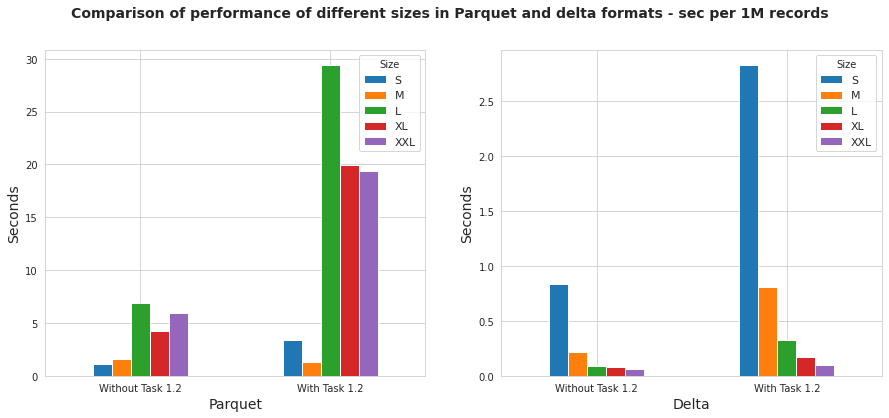

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create dataframes from the tables
parquet = {'Metric': [ 'Without Task 1.2', 'With Task 1.2'],
        'S': [ 1.09, 3.36],
        'M': [  1.63, 1.34],
        'L': [  6.85, 29.40],
        'XL': [ 4.26, 19.91],
        'XXL': [  5.91, 19.37]}
df1 = pd.DataFrame(parquet)
df1 = df1.set_index('Metric')

delta = {'Metric': [ 'Without Task 1.2', 'With Task 1.2'],
        'S': [ 0.84, 2.83],
        'M': [ 0.22, 0.81],
        'L': [ 0.09, 0.33],
        'XL': [  0.08, 0.17],
        'XXL': [ 0.06, 0.10]}
df2 = pd.DataFrame(delta)
df2 = df2.set_index('Metric')

# Set up the plot with two columns
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

# Plot the data for df1 and df2
df1.plot(kind='bar', ax=ax1, rot=0)
df2.plot(kind='bar', ax=ax2, rot=0)

# Add titles and labels for the left plot (df1)
ax1.set_xlabel('Parquet', fontsize=14)
ax1.set_ylabel('Seconds', fontsize=14)
ax1.legend(title='Size', fontsize=11)

# Add titles and labels for the right plot (df2)
ax2.set_xlabel('Delta', fontsize=14)
ax2.set_ylabel('Seconds', fontsize=14)
ax2.legend(title='Size', fontsize=11)

# Add a centered title for both plots
fig.suptitle('Comparison of performance of different sizes in Parquet and delta formats - sec per 1M records', fontsize=14, fontweight='bold')

# Show the plot
plt.show()



Conclusion: Delta and Parquet are two different file formats used for storing and managing large datasets in a distributed computing environment

The performance of two formats are compared based on the execution time taken per 1 million records
1) On Comparison with and without task 1.2(i.e, outlier detection) of parquet data format:
   * There is an increase in the execution time per million record as the file size increases from 'S' to 'L'
   * The execution time per million record for 'L' is higher compared to XL and XXL files. 
   * There is a decrease in the execution time per million record as the file size increases from 'L' to 'XXL'   
Parquet is a columnar storage file format that is highly optimized for reading and writing large datasets. It supports nested data structures and is particularly effective for queries that involve reading only a subset of columns from a large table. Parquet files are typically compressed, which can lead to significant storage savings.
   
   
2) On On Comparison with and without task 1.2(i.e, outlier detection) of parquet delta format:
   * The execution time per million records linearly decreases with increase in the file of the files   
Delta is a transactional storage format built on top of Parquet. Delta provides features such as ACID transactions, versioning and etc.Delta also optimizes the read and write operations by using features such as Z-ordering, data skipping, and caching which enables fast data processing while maintaining data integrity and consistency. It is particularly useful for use cases that require frequent updates to large datasets, such as real-time data pipelines, machine learning applications, and data warehousing.   

   
3) On comparison with delta and parquet files:  
In terms of performance, both file formats have their own strengths and weaknesses. Parquet is optimized for reading and writing large datasets quickly, and it provides good performance for analytical queries that involve complex aggregations and filtering operations. Delta is optimized for transactional processing and provides fast write and read performance for frequently updated datasets. Overall, delta files are much faster than parquet files